In [1]:
from clearml import Task

dataset = 'Adult_1_s'
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
tags = [dataset]
task_list = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter,  # Optional[Dict]
    tags=tags
)





In [2]:
len(task_list)

210

In [7]:
MAX_GRAD_NORMS = [200]
EPSILONS = [11.5, 3.2, 0.96, 0.72]
components = ['autoencoder', 'adversary', 'classifier']

In [8]:
import matplotlib.pyplot as plt
import numpy as np
best_epochs = {}
acc = {}
dp = {}
eod = {}
eop = {}
no_privacy = True
for MAX_GRAD_NORM_ in MAX_GRAD_NORMS:
    best_epoch_comp = {}
    acc_comp = {}
    dp_comp = {}
    eop_comp = {}
    eod_comp = {}
    for component in components:
        best_epoch_eps = {}
        acc_list = {}
        dp_list = {}
        eop_list = {}
        eod_list = {}
        for EPSILON_ in EPSILONS:
            MAX_GRAD_NORM = MAX_GRAD_NORM_
            EPSILON = EPSILON_
            l = [i.get_reported_scalars() for i in task_list if
                 'grad_norm='+str(MAX_GRAD_NORM) in i.data.tags and
                 component in i.data.tags and
                 "ε="+str(EPSILON) in i.data.tags
                ]
            if len(component) == 0:
                if no_privacy:
                    l = [i.get_reported_scalars() for i in task_list if
                     'autoencoder' not in i.data.tags and
                     'adversary' not in i.data.tags and
                     'classifier' not in i.data.tags
                    ]
                    MAX_GRAD_NORM = 0
                    EPSILON = 0
                    no_privacy = False
                else:
                    continue
            adv = [i['Adversary Loss']['test loss']['y'] for i in l]
            adv_mean = np.array(adv[0])
            
            cl = [i['Classifier Loss']['test loss']['y'] for i in l]
            cl_mean = np.array(cl[0])
            
            
            for i in range(1, len(adv)):
                adv_mean += np.array(adv[i])
                cl_mean += np.array(cl[i])
            adv_mean = np.array(adv_mean)
            cl_mean = np.array(cl_mean)
            adv_mean /= len(adv)
            cl_mean /= len(cl)
            

            w = int(len(adv_mean)*0.5)
            sm_y_adv = []
            sm_y_cl = []
            for i in range(len(adv_mean) - w):
                value = np.mean(adv_mean[i:i+w])
                sm_y_adv.append(value)
                value = np.mean(cl_mean[i:i+w])
                sm_y_cl.append(value)
            adv_epoch = np.argmax(sm_y_adv)
            cl_epoch = np.argmin(sm_y_cl)
            epoch_ = min(adv_epoch, cl_epoch)
            epoch_ = 180#max(epoch_, 50)
            print('MAX_GRAD_NORM:', MAX_GRAD_NORM, 'component:', component, 'eps:', EPSILON, 'best epoch:', epoch_)
            acc_, acc_unfair = [i['Accuracy']['LFR']['y'][epoch_] for i in l], [i['Accuracy']['Unfair']['y'][epoch_] for i in l]
            dp_, dp_unfair = [i['ΔDP']['LFR']['y'][epoch_] for i in l], [i['ΔDP']['Unfair']['y'][epoch_] for i in l] 
            eod_, eod_unfair = [i['ΔEOD']['LFR']['y'][epoch_] for i in l], [i['ΔEOD']['Unfair']['y'][epoch_] for i in l] 
            eop_, eop_unfair = [i['ΔEOP']['LFR']['y'][epoch_] for i in l], [i['ΔEOP']['Unfair']['y'][epoch_] for i in l]
            
            acc_list[EPSILON] = (np.mean(acc_), np.std(acc_, ddof=1), np.mean(acc_unfair))
            dp_list[EPSILON] = (np.mean(dp_), np.std(dp_, ddof=1), np.mean(dp_unfair))
            eod_list[EPSILON] = (np.mean(eod_), np.std(eod_, ddof=1), np.mean(eod_unfair))
            eop_list[EPSILON] = (np.mean(eop_), np.std(eop_, ddof=1), np.mean(eop_unfair))
            
            best_epoch_eps[EPSILON] = epoch_
            
        acc_comp[component] = acc_list
        dp_comp[component] = dp_list
        eod_comp[component] = eod_list
        eop_comp[component] = eop_list
        
        best_epoch_comp[component] = best_epoch_eps
        
    acc[MAX_GRAD_NORM] = acc_comp
    dp[MAX_GRAD_NORM] = dp_comp
    eop[MAX_GRAD_NORM] = eop_comp
    eod[MAX_GRAD_NORM] = eod_comp
    best_epochs[MAX_GRAD_NORM] = best_epoch_comp


MAX_GRAD_NORM: 200 component: autoencoder eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 200 component: autoencoder eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 200 component: autoencoder eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 200 component: autoencoder eps: 0.72 best epoch: 180
MAX_GRAD_NORM: 200 component: adversary eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 200 component: adversary eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 200 component: adversary eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 200 component: adversary eps: 0.72 best epoch: 180
MAX_GRAD_NORM: 200 component: classifier eps: 11.5 best epoch: 180
MAX_GRAD_NORM: 200 component: classifier eps: 3.2 best epoch: 180
MAX_GRAD_NORM: 200 component: classifier eps: 0.96 best epoch: 180
MAX_GRAD_NORM: 200 component: classifier eps: 0.72 best epoch: 180


In [5]:
print(acc[1.1]['autoencoder'])

KeyError: 1.1

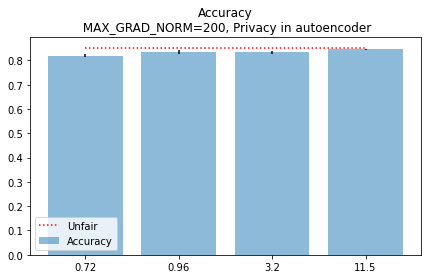

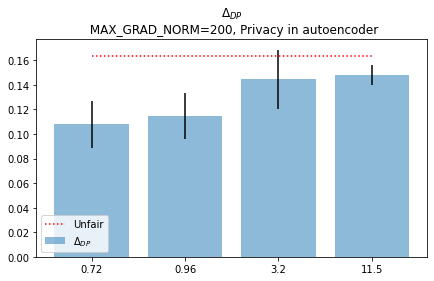

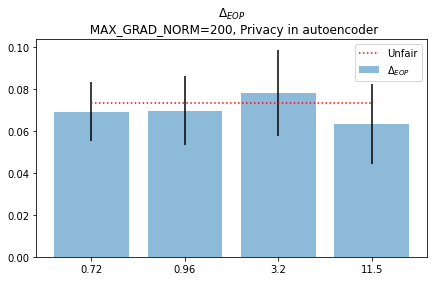

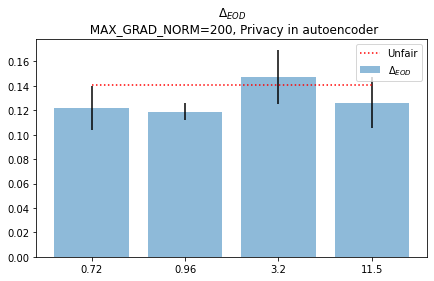

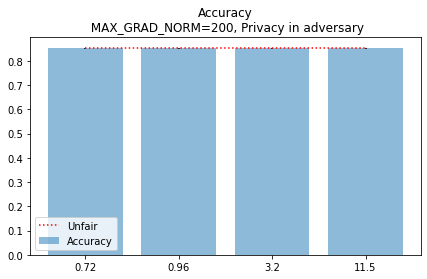

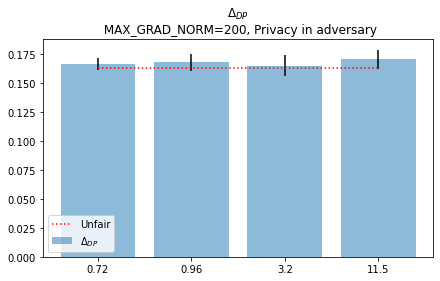

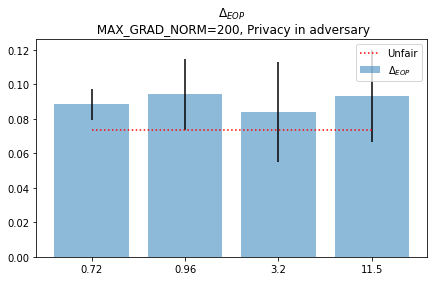

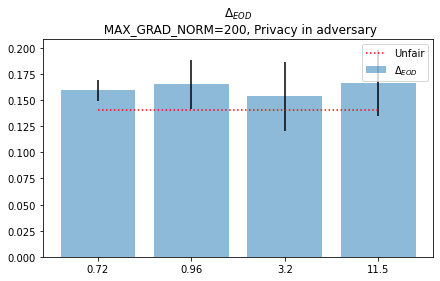

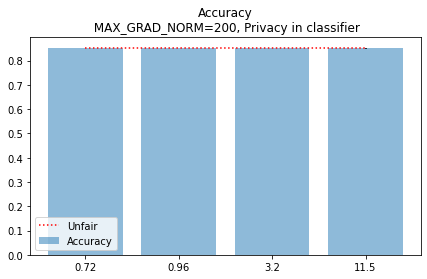

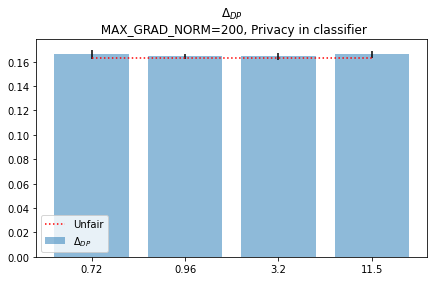

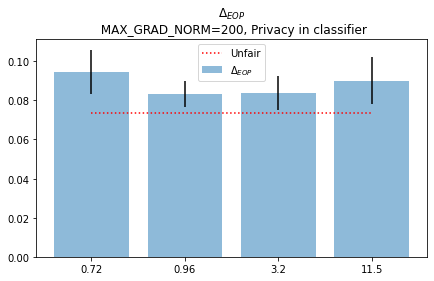

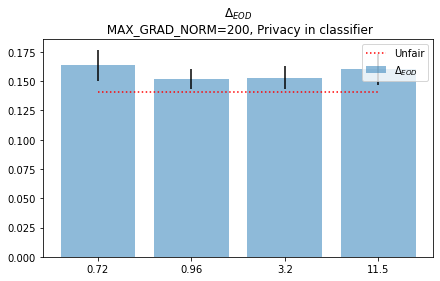

In [9]:
import matplotlib
%matplotlib inline
no_privacy = True
for MAX_GRAD_NORM_ in MAX_GRAD_NORMS:
    for component in components:
        MAX_GRAD_NORM = MAX_GRAD_NORM_
        EPSILONS_ = EPSILONS
        if len(component) == 0:
            if no_privacy:
                EPSILONS_ = [0]
                no_privacy = False
            else:
                continue
        labels = ["Accuracy", "$\Delta_{DP}$", '$\Delta_{EOP}$', '$\Delta_{EOD}$']
        y = [
            [acc[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][0] for EPSILON in sorted(EPSILONS_)]
        ]
        std = [
            [acc[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][1] for EPSILON in sorted(EPSILONS_)]
        ]
        unfair = [
            [acc[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [dp[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [eop[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)],
            [eod[MAX_GRAD_NORM][component][EPSILON][2] for EPSILON in sorted(EPSILONS_)]
        ]
        for p in range(len(y)):
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
            ax.bar(np.arange(len(EPSILONS_)), y[p], yerr=std[p], label=labels[p], alpha=0.5)
            title = labels[p] + "\n MAX_GRAD_NORM=" + str(MAX_GRAD_NORM) + ", Privacy in " + component if len(EPSILONS_) > 1\
            else labels[p] + "\n No privacy"
            ax.set_xticks(np.arange(len(EPSILONS_)))
            ax.set_xticklabels([str(i) for i in sorted(EPSILONS_)])
            ax.set_title(title)
            ax.plot(np.arange(len(EPSILONS_)), unfair[p], label="Unfair", linestyle='dotted', color='red') if len(EPSILONS_) > 1\
            else ax.plot(np.arange(len(EPSILONS_) + 1), [unfair[p], unfair[p]], label="Unfair", linestyle='dotted', color='red')
            ax.legend()
            plt.show()
            

            
            

In [36]:
from data_processing import preprocessing_adult_1, preprocessing_adult_2
import pandas as pd
from utils import convert2torch

In [95]:
train_data = pd.read_csv("./dataset/adult.data.csv")
test_data = pd.read_csv("./dataset/adult.test.csv")
X_train, y_train, S_train, data = preprocessing_adult_1(train_data)
X_test, y_test, S_test, data_ = preprocessing_adult_1(test_data)

In [71]:
X_train, X_test, y_train, y_test, S_train, S_test = convert2torch(X_train, X_test, y_train, y_test, S_train,
                                                                  S_test)
print([i.shape for i in[X_train, X_test, y_train, y_test, S_train, S_test]])

[torch.Size([32561, 96]), torch.Size([16282, 96]), torch.Size([32561]), torch.Size([16282]), torch.Size([32561]), torch.Size([16282])]


In [97]:
data = preprocessing_adult_2("income", "sex")
S_train = data["attr_train"]
S_test = data["attr_test"]
X_train = data["x_train"]
X_test = data["x_test"]
y_train = data["y_train"]
y_test = data["y_test"]

In [81]:
from scipy import stats
stats.describe(S_test)

DescribeResult(nobs=2228, minmax=(0, 1), mean=0.5, variance=0.25011225864391556, skewness=0.0, kurtosis=-2.0)

In [98]:
S_test[len(S_test) - 10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [99]:
S_test[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [84]:
X_train, X_test, y_train, y_test, S_train, S_test = convert2torch(X_train, X_test, y_train, y_test, S_train,
                                                                  S_test)
print([i.shape for i in[X_train, X_test, y_train, y_test, S_train, S_test]])

[torch.Size([30162, 112]), torch.Size([2228, 112]), torch.Size([30162]), torch.Size([2228]), torch.Size([30162]), torch.Size([2228])]


In [85]:
from sklearn.linear_model import LogisticRegression
from fairness_metrics import cross_val_fair_scores
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
results = {}
clr = LogisticRegression(max_iter=1000)
kfold = KFold(n_splits=5)
acc_, dp_, eqodd_, eopp_ = cross_val_fair_scores(clr, X_test.cpu().detach(
).numpy(), y_test.cpu().detach().numpy(), kfold, S_test.cpu().detach().numpy())
results["LR"] = ([np.mean(acc_), np.mean(dp_), np.mean(eqodd_), np.mean(eopp_)], [
                 np.std(acc_), np.std(dp_), np.std(eqodd_), np.std(eopp_)])

D:\work\Projects\Programming\PythonProjects\UniverInnopolis\ML\Fairness\differentially-private-fair-rep\fairness_metrics.py:11: RuntimeWarning: invalid value encountered in true_divide
  beta_1 = np.sum(np.logical_and(y_pred == 1, s == 0)) / \
D:\work\Projects\Programming\PythonProjects\UniverInnopolis\ML\Fairness\differentially-private-fair-rep\fairness_metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha_1 = np.sum(np.logical_and(y_pred == 1, np.logical_and(y_true == 1, s == 0))) / float(
D:\work\Projects\Programming\PythonProjects\UniverInnopolis\ML\Fairness\differentially-private-fair-rep\fairness_metrics.py:37: RuntimeWarning: invalid value encountered in true_divide
  alpha_2 = np.sum(np.logical_and(y_pred == 1, np.logical_and(y_true == 0, s == 0))) / float(np.sum(
D:\work\Projects\Programming\PythonProjects\UniverInnopolis\ML\Fairness\differentially-private-fair-rep\fairness_metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  beta

In [86]:
results

{'LR': ([0.6773698795787777, nan, nan, nan],
  [0.11112828938718398, nan, nan, nan])}